<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/CNNmilestone/DUDL_CNNmilestone_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import a dataset

In [3]:
# Transformations
transform = T.Compose([T.ToTensor(),
                       T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Import the data and simultaneously apply the transform
train_set    = torchvision.datasets.CIFAR10(root='./data', train=True,   download=True, transform=transform)
dev_test_set = torchvision.datasets.CIFAR10(root='./data', train=False,  download=True, transform=transform)

# Split the devtest into 02 separate sets
rand_idx = np.random.permutation(10000) # A random permutation of indices
dev_set  = Subset(dataset=dev_test_set, indices=rand_idx[:6000])
test_set = Subset(dataset=dev_test_set, indices=rand_idx[6000:])

# Transform to dataloaders
batch_size   = 32
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader   = DataLoader(dataset=dev_set,   batch_size=batch_size)
test_loader  = DataLoader(dataset=test_set,  batch_size=len(test_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Check out the shape of the datasets
print(f'Data shapes (train/dev/test):\n {len(train_set)}\n {len(dev_set)} \n {len(test_set)}')

# The range of pixel intensity values
print(f'\nData value range: {np.min(train_set.data)} -> {np.max(train_set.data)}')

# The unique categories
print(f'\nData categories: {train_set.classes}')

Data shapes (train/dev/test):
 50000
 6000 
 4000

Data value range: 0 -> 255

Data categories: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x32x32.
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


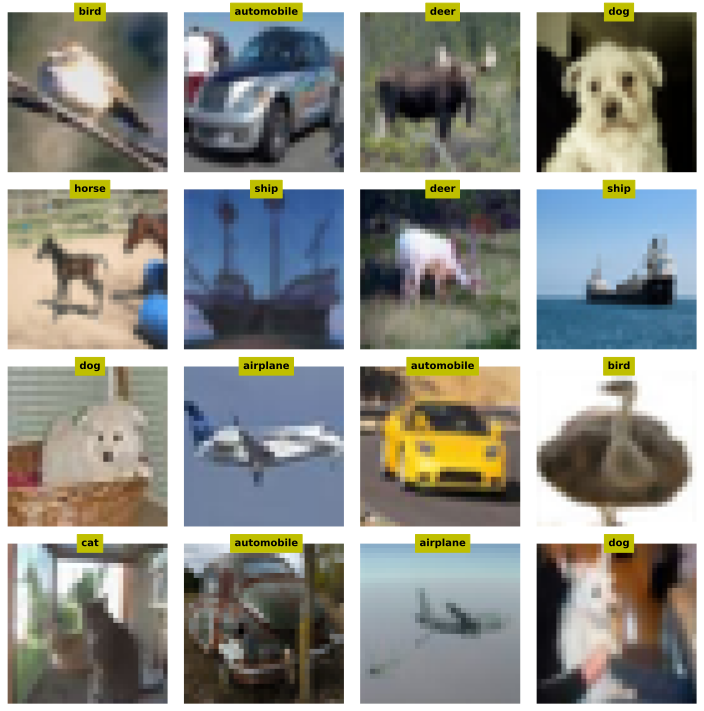

In [8]:
# Inspect a few random images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for (i, ax) in enumerate(axs.flatten()):
    # Extract that image (need to transpose it back to 32*32*3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5 # Undo normalization

    # And its label
    label = train_set.classes[y[i]]

    ax.imshow(pic)
    ax.text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Create the DL model

In [9]:
def make_the_net(print_toggle=False):
    """
    CNN_ HOW_LOW
    """
    class cnn_net(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            ######################## FEATURE MAP LAYERS ########################
            self.conv1  = nn.Conv2d(3, 64, kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=64)
                # (32 + 2*1 - 3)/1 + 1 = 32/2 = 16
            
            self.conv2  = nn.Conv2d(64, 128, kernel_size=3)
            self.bnorm2 = nn.BatchNorm2d(num_features=128)
                # (16 + 2*0 - 3)/1 + 1 = 14/2 = 7
            
            self.conv3  = nn.Conv2d(128, 256, kernel_size=3)
            self.bnorm3 = nn.BatchNorm2d(num_features=256)
                # (7 + 2*0 - 3)/1 + 1 = 5/2 = 2

            ######################## LINEAR DECISION LAYERS ####################
            self.fc1 = nn.Linear(2 * 2 * 256, 256)
            self.fc2 = nn.Linear(256, 64)
            self.fc3 = nn.Linear(64, 10)

        
        def forward(self, x):
            # Convolution -> Maxpool -> Batchnorm -> Relu
            if self.print:    print(f'Input:            {list(x.shape)}')

            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:    print(f'First CPR Block:  {list(x.shape)}')

            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:    print(f'Second CPR Block: {list(x.shape)}')

            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            if self.print:    print(f'Third CPR Block:  {list(x.shape)}')

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x       = x.view(-1, int(n_units))
            if self.print:    print(f'Vectorized:       {list(x.shape)}')

            # Linear layer
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(input=x, p=0.5, training=self.training)
            x = self.fc2(x)
            x = F.dropout(input=x, p=0.5, training=self.training)
            x = self.fc3(x)
            if self.print:    print(f'Final output:     {list(x.shape)}')

            return x
    
    # Create the model instance
    net = cnn_net(print_toggle)

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_func, optimizer

In [10]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net(print_toggle=True)

X, y = iter(train_loader).next()
y_hat = net(X)

print(''), print(f'Output size: {y_hat.shape}')

loss = loss_func(y_hat, torch.squeeze(y))
print(''), print(f'Loss: {loss}')

Input:            [32, 3, 32, 32]
First CPR Block:  [32, 64, 16, 16]
Second CPR Block: [32, 128, 7, 7]
Third CPR Block:  [32, 256, 2, 2]
Vectorized:       [32, 1024]
Final output:     [32, 10]

Output size: torch.Size([32, 10])

Loss: 2.360753059387207


(None, None)

# Create a function that trains the model

In [11]:
def train_the_model():
    """
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    dev_loss   = torch.zeros(num_epochs)
    train_acc  = torch.zeros(num_epochs)
    dev_acc    = torch.zeros(num_epochs)

    # Send the model to the GPU
    net.to(device)

    # Loop over epochs
    for epoch_i in range(num_epochs):
        net.train()

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:

            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and Error from this batch
            batch_loss.append(loss.item())
            batch_acc .append(torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_acc [epoch_i] = 100 * np.mean(batch_acc)

        # Test accuracy
        net.eval()
        batch_acc  = []
        batch_loss = []

        for X, y in dev_loader:
            
            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                y_hat = net(X)
                loss  = loss_func(y_hat, y)
            
            batch_loss.append(loss.item())
            batch_acc .append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        # End of batch loop
        dev_loss[epoch_i] = np.mean(batch_loss)
        dev_acc [epoch_i] = 100 * np.mean(batch_acc)

    # End epochs

    return train_loss, dev_loss, train_acc, dev_acc, net

# Run the model and show the results!

In [12]:
# ~2 minutes with 10 epochs on GPU
train_loss, dev_loss, train_acc, dev_acc, net = train_the_model()

In [15]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  y_hat = net(X)
  loss = loss_func(y_hat,y)

# loss and accuracy from this batch
test_loss = loss.item()
test_acc  = 100*torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item()

No handles with labels found to put in legend.


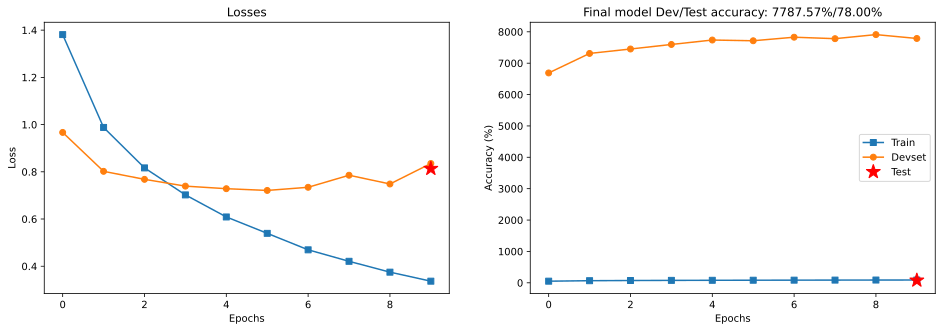

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(dev_loss,   'o-', label='Dev')
ax[0].plot(len(dev_loss) -1, test_loss, 'r*', markersize=15, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')
ax[1].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(dev_acc,   'o-', label='Devset')
ax[1].plot(len(dev_acc) -1, test_acc, 'r*', markersize=15, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model Dev/Test accuracy: {dev_acc[-1]:.2f}%/{test_acc:.2f}%')
ax[1].legend()

plt.show()